In [1]:
import torch
import torch.nn as nn
import numpy as np
import glob
import random

from scipy.io import wavfile
import matplotlib.pyplot as plt
from IPython.display import Audio as audio
import IPython.display as ipd

## Softmax & Crossentropy Loss

In [2]:
y = torch.tensor([[1.,0,0]])
y_hat = torch.tensor([[2,-1.2,3]])

# Softmax
y_hat_softmax = torch.exp(y_hat) / torch.sum(torch.exp(y_hat))
print(y_hat_softmax)

# Cross Entropy Loss
CEloss = -torch.sum(y*torch.log(y_hat_softmax))
print(CEloss)

tensor([[0.2660, 0.0108, 0.7231]])
tensor(1.3242)


In [3]:
y = torch.tensor([[1.,0,0]])
y_hat = torch.tensor([[2,-1.2,3]])

# Softmax
y_hat_softmax = y_hat.softmax(dim=1)
print(y_hat_softmax)

# Cross Entropy Loss
CEloss = nn.CrossEntropyLoss()
print(CEloss(y_hat_softmax, torch.argmax(y, dim=1)))
print(CEloss(y_hat, y))
print(CEloss(y_hat, torch.argmax(y, dim=1)))


tensor([[0.2660, 0.0108, 0.7231]])
tensor(1.3242)


## Data Loader

In [4]:
voice_list = glob.glob('Homework1/*_me.wav')
music_list = glob.glob('Homework1/*_music.wav')
print(len(voice_list),len(music_list))

39 41


In [5]:
def mywav_iter(batch_size, flist, L):
    N = len(flist)
    inds = list(range(N))
    random.shuffle(inds)
    
    for i in range(0, N, batch_size):
        batch_inds = inds[i:min(i+batch_size, N)]
        batch_wavs = np.zeros((len(batch_inds),L))
        batch_lbls = np.zeros((len(batch_inds),1))
    
        for bi in range(0, len(batch_inds)):
            d = wavfile.read(flist[batch_inds[bi]])
            if len(d[1].shape)>1:
                ds = d[1][::6,0]
            else:
                ds = d[1][::6]
                
            t0 = np.random.randint(0, ds.shape[0]-L, 1)[0]
            l = flist[batch_inds[bi]].split('.wav')[-2].split('_')[-1]
            batch_wavs[bi] = ds[t0:t0+L] + np.random.randn(L)*0.1
            batch_wavs[bi] = (batch_wavs[bi]-np.mean(batch_wavs[bi]))/np.std(batch_wavs[bi])
                
            if l=='me':
                batch_lbls[bi] = 1
            elif l=='music':
                batch_lbls[bi] = 0

        yield batch_wavs, batch_lbls

In [6]:
batch_size = 4
flist = voice_list + music_list
L = 4000
fs = 8000

(4, 4000) (4, 1)


[1.]


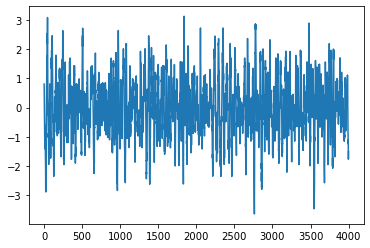

In [7]:
data_iter = mywav_iter(batch_size, flist, L)
for x,y in data_iter:
    print(x.shape, y.shape)
    for i in range(len(x)):
        ipd.display(audio(x[i],rate=fs))
        print(y[i])
        plt.plot(x[i])
        plt.show()
        break
    break

## Train

In [8]:
num_epoch = 1000
L = 4000
batch_size = 16
lr = 0.001

model = nn.Sequential(nn.Linear(L, 2*L),nn.ReLU(),nn.Linear(2*L,2))   
loss = nn.CrossEntropyLoss(reduction='mean')
alg = torch.optim.SGD(model.parameters(),lr)

loss_train_epoch = []
loss_valid_epoch = []

flist = voice_list[:32] + music_list[:32]
flist_vd = voice_list[32:39] + music_list[32:39]

# loop for learning
for j in np.arange(0,num_epoch):
  # training
  data_iter = mywav_iter(batch_size, flist, L)
  loss_train = []
  model.train()
  for batch_X,batch_y in data_iter:
    batch_X = torch.tensor(batch_X).float()
    batch_y = torch.tensor(batch_y).long().squeeze()
    y_hat = model(batch_X)           # 1. forward
    l = loss(y_hat, batch_y)         # 2. loss calculation
    l.backward()                     # 3. backward
    alg.step()                       # 4. parameter update
    alg.zero_grad()      
    loss_train.append(l.detach())
  loss_train_epoch.append(torch.mean(torch.stack(loss_train)))

  # validation
  data_iter_vd = mywav_iter(batch_size, flist_vd, L)
  loss_valid = []
  model.eval()
  for batch_X,batch_y in data_iter_vd:
    batch_X = torch.tensor(batch_X).float()
    batch_y = torch.tensor(batch_y).long().squeeze()
    with torch.no_grad():
      y_hat = model(batch_X)         # 1. forward
      l = loss(y_hat, batch_y)       # 2. loss calculation
    loss_valid.append(l.detach())
  loss_valid_epoch.append(torch.mean(torch.stack(loss_valid)))

  if j%10==0:
    print(f'Epoch {j} loss_train {loss_train_epoch[-1]:.4f} loss_valid {loss_valid_epoch[-1]:.4f}')


Epoch 0 loss_train 0.7055 loss_valid 0.7557
Epoch 10 loss_train 0.7158 loss_valid 0.7293
Epoch 20 loss_train 0.7303 loss_valid 0.6864
Epoch 30 loss_train 0.6937 loss_valid 0.6424
Epoch 40 loss_train 0.6950 loss_valid 0.7062
Epoch 50 loss_train 0.6604 loss_valid 0.7138
Epoch 60 loss_train 0.6893 loss_valid 0.6695
Epoch 70 loss_train 0.6858 loss_valid 0.6812
Epoch 80 loss_train 0.6992 loss_valid 0.6799
Epoch 90 loss_train 0.6480 loss_valid 0.6500
Epoch 100 loss_train 0.6901 loss_valid 0.6825
Epoch 110 loss_train 0.6380 loss_valid 0.6930
Epoch 120 loss_train 0.6632 loss_valid 0.6299
Epoch 130 loss_train 0.6555 loss_valid 0.6218
Epoch 140 loss_train 0.6801 loss_valid 0.6147
Epoch 150 loss_train 0.6337 loss_valid 0.7062
Epoch 160 loss_train 0.6209 loss_valid 0.6066
Epoch 170 loss_train 0.6348 loss_valid 0.7822
Epoch 180 loss_train 0.6215 loss_valid 0.6016
Epoch 190 loss_train 0.6259 loss_valid 0.6472
Epoch 200 loss_train 0.6259 loss_valid 0.6633
Epoch 210 loss_train 0.6410 loss_valid 0.7059

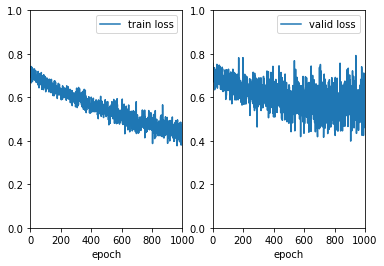

In [12]:
plt.subplot(121)
plt.plot(loss_train_epoch, label='train loss')
plt.axis([0,num_epoch,0,1])
plt.xlabel('epoch')
plt.legend()
plt.subplot(122)
plt.plot(loss_valid_epoch, label='valid loss')
plt.legend()
plt.axis([0,num_epoch,0,1])
plt.xlabel('epoch')
plt.show()

## Inference

In [10]:
j=3
#print(flist_vd[j])
d = wavfile.read(flist_vd[j])
if len(d[1].shape)>1:
    ds = d[1][::6,0]
else:
    ds = d[1][::6]
ds = torch.tensor(ds).float()
prob_0 = torch.zeros_like(torch.tensor(ds))
prob_1 = torch.zeros_like(torch.tensor(ds))
for n in np.arange(0,len(ds)-L,L//16):
    ds_seg = ds[n:n+L]
    ds_seg = (ds_seg-torch.mean(ds_seg))/torch.std(ds_seg)
    y_hat = model(ds_seg)
    y_hat = torch.softmax(y_hat, dim=0)
    prob_0[n:n+L//16] = y_hat[0]
    prob_1[n:n+L//16] = y_hat[1]


/var/folders/n7/jq4g2jg94p31535vqfnh88b40000gn/T/ipykernel_14609/3800133287.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prob_0 = torch.zeros_like(torch.tensor(ds))
/var/folders/n7/jq4g2jg94p31535vqfnh88b40000gn/T/ipykernel_14609/3800133287.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prob_1 = torch.zeros_like(torch.tensor(ds))


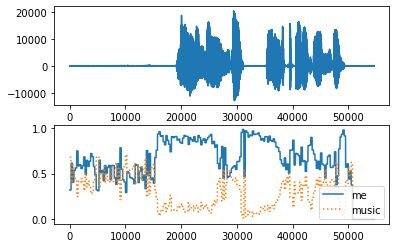

In [11]:
plt.subplot(211)
plt.plot(ds)
plt.subplot(212)
plt.plot(prob_1,label='me')
plt.plot(prob_0,':',label='music')
plt.legend()
plt.show()